In [1]:
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import random
import seaborn as sns

#preprocessing
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from spacy.lang.en.stop_words import STOP_WORDS

#model
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn import metrics
from sklearn.svm import SVC

#eval
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve



In [2]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#select data
data = pd.read_csv('/content/drive/MyDrive/BINUS/Pelajaran/Semester 3/Artificial Intelligence/cyberbullying_tweets.csv')


In [4]:
#preprocessing
#split data

X_train, X_test, y_train, y_test = train_test_split(data['tweet_text'], data['cyberbullying_type'], test_size=0.2, random_state=42)

#text preprocessing
ps = PorterStemmer()

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters
    text = re.sub(r'\W', ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Remove stopwords and perform stemming
    text = ' '.join([ps.stem(word) for word in text.split() if word not in STOP_WORDS])

    return text

#apply preprocess
X_train = X_train.apply(clean_text)
X_train = X_train[X_train.str.split().str.len() >= 3]
y_train = y_train[X_train.index]

X_test = X_test.apply(clean_text)
X_test = X_test[X_test.str.split().str.len() >= 3]
y_test = y_test[X_test.index]

In [5]:
#pipeline for rf
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svd', TruncatedSVD(n_components=100)),  # Reducing to 100 components as an example
    ('clf', RandomForestClassifier())
    ])


pipeline_rf.fit(X_train, y_train)
predictions_rf = pipeline_rf.predict(X_test)
predictions_prob_rf = pipeline_rf.predict_proba(X_test)



In [6]:
#model eval
print("RF Classification Report:")
print(classification_report(y_test,predictions_rf,digits=5))
print("ROC-AUC : ", round(roc_auc_score(y_test, predictions_prob_rf, multi_class='ovr'), 5))

RF Classification Report:
                     precision    recall  f1-score   support

                age    0.93948   0.98061   0.95961      1599
          ethnicity    0.95922   0.95742   0.95832      1597
             gender    0.85844   0.81794   0.83770      1505
  not_cyberbullying    0.53309   0.47233   0.50087      1518
other_cyberbullying    0.49344   0.55052   0.52042      1435
           religion    0.92703   0.93355   0.93028      1565

           accuracy                        0.79141      9219
          macro avg    0.78512   0.78540   0.78453      9219
       weighted avg    0.79121   0.79141   0.79061      9219

ROC-AUC :  0.95132


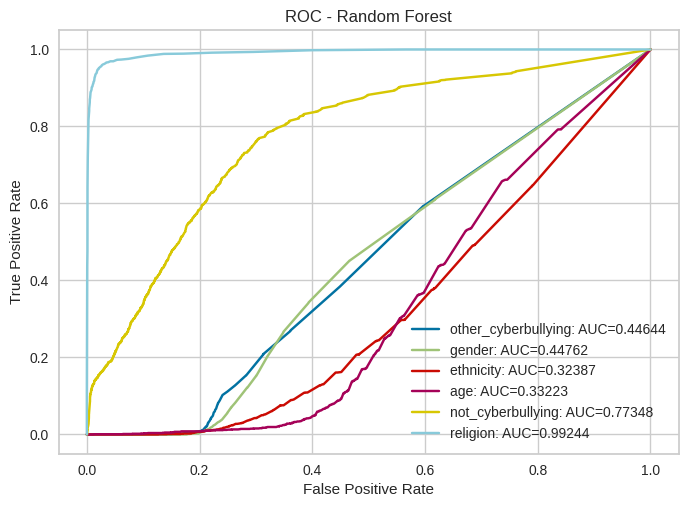

In [7]:
#roc-auc
classes = y_train.unique().tolist()
y_test = label_binarize(y_test, classes=classes)
y_test[0:6, :]

fpr_rf = dict()
tpr_rf = dict()

# for each class
for i in range(len(classes)):

    # determine precision and recall at various thresholds
    # in a 1 vs all fashion
    fpr_rf[i], tpr_rf[i], _ = roc_curve(
        y_test[:, i], predictions_prob_rf[:, i])

    plt.plot(fpr_rf[i], tpr_rf[i], label=f'{classes[i]}: AUC={round(auc(fpr_rf[i], tpr_rf[i]),5)}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Random Forest')
plt.legend(loc="lower right")
plt.show()

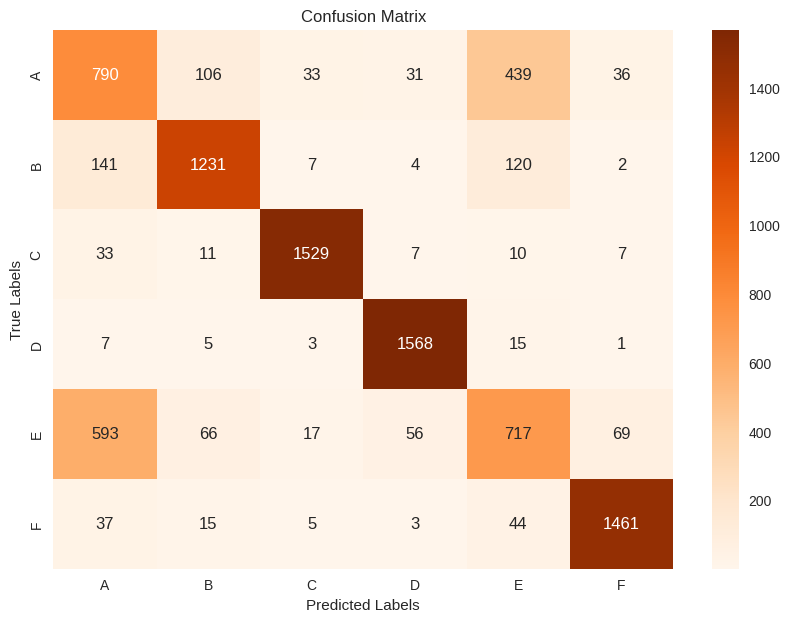

In [8]:
#confusion matrix

label_map = {'other_cyberbullying' : 0,  'gender' : 1, 'ethnicity' : 2, 'age' : 3, 'not_cyberbullying' : 4, 'religion' : 5}
y_pred_integers = np.array([label_map[label] for label in predictions_rf])
c_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_integers)

# print(c_matrix)

# Example confusion matrix (replace with your actual data)
conf_matrix = np.array(c_matrix)

# Create a DataFrame for better labeling
class_labels = ['A', 'B', 'C', 'D', 'E', 'F']
df_cm = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Oranges', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
